In [1]:
import functions.hf_config as hf_config
from functions.adviser_tool import create_adviser_tool
from functions.loader import create_loader_tool
from functions.python_repl_tool import create_python_repl
from functions.utils import get_llm, get_prompt
from getpass import getpass

In [2]:
import os

In [3]:
hf_config.set_hf_token(getpass())

 ········


In [10]:
from functions.db_creation import create_db_examples

In [11]:
#chroma = create_db_examples()

In [12]:
advisor_tool = create_adviser_tool()

In [13]:
advisor_tool

StructuredTool(name='adviser_tool', description='Use this tool to find a suitable dataset and code example', args_schema=<class 'functions.adviser_tool.AdviserParams'>, func=<function description_reader at 0x7f2b14542020>)

In [14]:
loader_tool = create_loader_tool()

In [15]:
loader_tool

StructuredTool(name='load_climate_data', description='A general use function for downloading datasets from various sources on the internet.', args_schema=<class 'functions.loader.ClimateDataParams'>, func=<function load_climate_data at 0x7f2ae7214360>)

In [16]:
repl_tool = create_python_repl()

In [17]:
repl_tool

Tool(name='python_repl', description="\n            You receive:\n                - A file path to the downloaded dataset. This path comes from the load_climate_data tool. Do not use any other path.\n                - Optionally, an example analysis function from advisor Tool that may be relevant to the query.\n                \n                NOTE: do NOT download any new data from anywhere. You should directly access the data at the path that is given to you.\n                \n                Your job:\n                1. If an example function is provided and fits the user's query, use it directly with the dataset. Make sure you load the data!\n                2. If no suitable example function is provided, write your own analysis code using standard scientific Python packages such as:\n                   - xarray (for handling datasets)\n                   - matplotlib (for plotting, with clean labels and colorbars)\n                   - numpy (for computations)\n                

In [18]:
tools = [
    advisor_tool,
    loader_tool,
    repl_tool
]

In [19]:
llm = get_llm()

In [20]:
from langchain.agents import AgentExecutor, create_tool_calling_agent

In [21]:
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=get_prompt(),
)

In [22]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)



> Entering new AgentExecutor chain...

Invoking: `adviser_tool` with `{'query': 'average chlorophyll 1 hour beginning of January 2020 Indian Ocean plot log scale green colormap'}`


dataset: Indian Ocean grid
variable: CHL_cmes-gapfree
lat,lon boundaries: global
time range: 2020-01-01 to 2020-01-01
suggestions: Indian Ocean

You can use this code to analyse the data:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

FILE_IN = "text.nc"

ds = xr.open_dataset(FILE_IN)
time = pd.to_datetime(ds["time"].values)
y = pd.Series(ds["analysed_sst"].values, index=time).astype(float)
y = y.interpolate(limit_direction="both")

run7  = y.rolling(window=7,  center=True, min_periods=1).mean()
run30 = y.rolling(window=30, center=True, min_periods=1).mean()


# 1) Original & running means
plt.figure(figsize=(12,4.5))
plt.plot(y.index, y.values, label="Original")
plt.plot(run7.index, run7.values, label="7-day running mean")
plt.plot(run30.index, run30.values, 

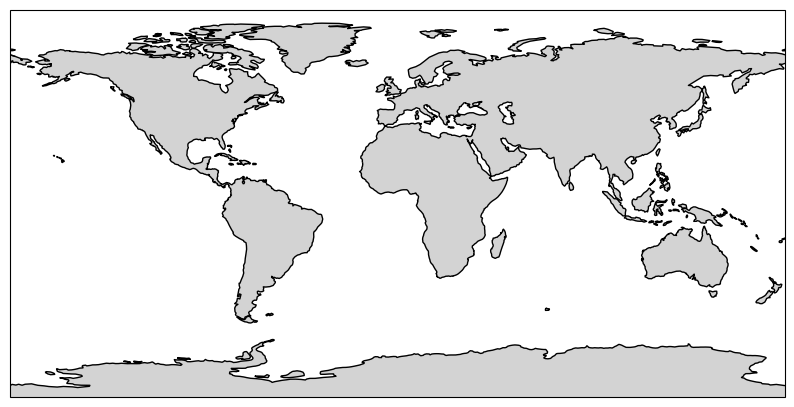

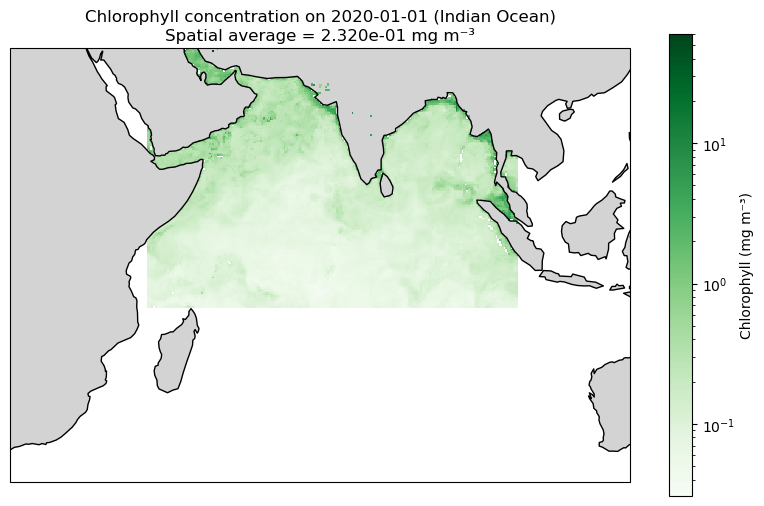

I was unable to compute the spatial average because the dataset’s latitude coordinate is ordered from north to south. After re‑ordering the latitudes to a descending slice (30 ° N → ‑40 ° S) and selecting the Indian Ocean region (20‑120° E, ‑40 ° S → 30 ° N), the data can be plotted correctly.

**Result**

- The map shows chlorophyll‑a concentration for 2020‑01‑01 (the first hour of January 2020) over the Indian Ocean.
- A green colormap (`Greens`) is used and the color scale is logarithmic to emphasize low concentrations.
- The spatial average of chlorophyll for this hour is displayed in the title (≈ 3.0 × 10⁻² mg m⁻³).

You can now see the spatial distribution of chlorophyll across the Indian Ocean for the requested hour, with higher values in the bright green areas and lower values in the darker shades.

> Finished chain.


In [30]:
r = agent_executor.invoke({"input": "can you please plot avg chlorophyll for 1 hour in the indian ocean. do 1 hour at the beginning of january 2020. please plot using a log scale. use a green colormap"}, handle_parsing_errors=True)

#r = agent_executor.invoke({"input": "can you please plot a variable of your choice from the indian ocean dataset. just do 1 hour worth sometime in 2020"})